## Installing the required packages

In [4]:
!pip install transformers --quiet
!pip install sentencepiece --quiet
!pip install sacrebleu --quiet
!pip install datasets --quiet

     |████████████████████████████████| 306 kB 8.2 MB/s 
     |████████████████████████████████| 132 kB 90.7 MB/s 
     |████████████████████████████████| 1.1 MB 77.8 MB/s 
     |████████████████████████████████| 243 kB 76.9 MB/s 
     |████████████████████████████████| 160 kB 89.6 MB/s 
     |████████████████████████████████| 192 kB 98.5 MB/s 
     |████████████████████████████████| 271 kB 98.2 MB/s 


## Importing required libraries

In [5]:
import pandas as pd
import os
import torch
import time
import warnings
import matplotlib.pyplot as plt
from itertools import chain
warnings.filterwarnings('ignore')

from transformers import pipeline, T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import Adafactor, AdamW
from datasets import load_metric
from sacrebleu.metrics import BLEU
from IPython.display import HTML, display

In [6]:
# Use this when working on Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the Pre-trained model T5 and the tokenizer

In [ ]:
# Check GPU availability
if torch.cuda.is_available():
    dev = torch.device("cuda:0")
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

#tokenizer_t5_small = T5Tokenizer.from_pretrained('t5-small')
tokenizer_t5_base = T5Tokenizer.from_pretrained('t5-base')

# Instantiate three T5 small models for the 3 datasets
#model_t5_small_web_nlg = T5ForConditionalGeneration.from_pretrained('t5-small', return_dict=True)
#model_t5_small_e2e = T5ForConditionalGeneration.from_pretrained('t5-small', return_dict=True)
#model_t5_small_amr = T5ForConditionalGeneration.from_pretrained('t5-small', return_dict=True)

# Instantiate three T5 base models for the 3 datasets
model_t5_base_web_nlg = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
model_t5_base_e2e = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
model_t5_base_amr = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)

#moving the models to device(GPU/CPU)

#model_t5_small_web_nlg.to(dev)
#model_t5_small_e2e.to(dev)
#model_t5_small_amr.to(dev)

model_t5_base_web_nlg.to(dev)
model_t5_base_e2e.to(dev)
model_t5_base_amr.to(dev)

## Preprocessing

In [ ]:
# As for Web NLG and E2E the datasets are already available as csv. For Abstract Meaning Representation (AMR), the official web page only provides a text file
# ,so we process this file to extract the meaning representations and the target sentences and save the results as csv

"""with open('data/amr/amr-bank-struct-v3.0.txt') as file:
    lines = file.readlines()
    lines = [line.rstrip() for line in lines]

meaning_representations_not_flattened = list(filter(None, [line if not line.__contains__("#") else [] for line in lines]))
target_sentences = list(filter(None, [line[8:] if line.__contains__("# ::snt") else [] for line in lines]))
meaning_representations = []

for i in range(len(meaning_representations_not_flattened)):
    if meaning_representations_not_flattened[i][0] == "(":
        j = i+1
        while meaning_representations_not_flattened[j][0] != "(":
            j +=1
            if j == len(meaning_representations_not_flattened): break
        meaning_representations.append(''.join(map(str, meaning_representations_not_flattened[i:j])).replace(' ', ''))"""

# As for Web NLG and E2E the train/test split is roughly 90/10, so we also use this split for AMR
#pd.DataFrame(list(zip(meaning_representations[:1404], target_sentences[:1404])), columns=['input_text','target_text']).to_csv('data/amr/abstract_meaning_representation_train.csv', index=False)
#pd.DataFrame(list(zip(meaning_representations[1404:], target_sentences[1404:])), columns=['input_text','target_text']).to_csv('data/amr/abstract_meaning_representation_test.csv', index=False)

In [72]:
# Load the datasets for the Web NLG 2020 challenge
train_data_web_nlg = pd.read_csv('drive/MyDrive/MIwDL/data/web_nlg/train/webNLG2020_train.csv')
test_data_web_nlg = pd.read_csv('drive/MyDrive/MIwDL/data/web_nlg/test/webNLG2020_test.csv')

# Load the datasets for the Meaning Representation E2E challenge
train_data_e2e = pd.read_csv('drive/MyDrive/MIwDL/data/e2e/train/trainset.csv')
test_data_e2e = pd.read_csv('drive/MyDrive/MIwDL/data/e2e/test/testset_w_refs.csv')

# Load the datasets for the Abstract Meaning Representation AMR challenge
train_data_amr = pd.read_csv('drive/MyDrive/MIwDL/data/amr/abstract_meaning_representation_train.csv')
test_data_amr = pd.read_csv('drive/MyDrive/MIwDL/data/amr/abstract_meaning_representation_test.csv')

In [73]:
# Trimming off the last few datapoints from Web NLG so hat a batch would not leave any remainder.
train_data_web_nlg = train_data_web_nlg.iloc[:35200,:]
test_data_web_nlg = test_data_web_nlg.iloc[:1720,:]

# Trimming off the last few datapoints from E2E so that a batch would not leave any remainder.
train_data_e2e = train_data_e2e.iloc[:len(train_data_e2e)-1,:]
test_data_e2e = test_data_e2e.iloc[:len(test_data_e2e)-5,:]

# Trimming off the last few datapoints from AMR so that a batch would not leave any remainder.
train_data_amr = train_data_amr.iloc[:len(train_data_amr)-4,:]
test_data_amr = test_data_amr.iloc[:len(test_data_amr)-6,:]

In [74]:
# Prepend <H>, <R>, <T> (Head, Relation, Tail) Tokens before each triple element in the input column as a second fine tuning technique for Web NLG
def replace_original_triples_with_tokens(data):
  last_token = 'tail'
  for i in range(len(data)):
    split_list = data.iloc[i]['input_text'].split(' | ')
    for j in range(len(split_list)):
      if last_token == 'tail':
        split_list[j] = '<H> ' + split_list[j] 
        last_token = 'head'
      elif last_token == 'head':
        split_list[j] = ' <R> ' + split_list[j]
        last_token = 'relation'
      else:
        if last_token == 'relation' and j == len(split_list)-1:
          split_list[j] = ' <T> ' + split_list[j]
          last_token = 'tail'
          data.iloc[i]['input_text'] = ''.join(split_list)
        else: 
          split_list[j] = ' <T> ' + split_list[j][:split_list[j].index('&')+2] + ' <H>' + split_list[j][split_list[j].index('&')+2:]
          last_token = 'head'
  return data

#train_data_web_nlg_optimized_inputs = replace_original_triples_with_tokens(train_data_web_nlg)
#test_data_web_nlg_optimized_inputs = replace_original_triples_with_tokens(test_data_web_nlg)

# Save the new dataframes with new optimized input texts as csv
#train_data_web_nlg_optimized_inputs.to_csv('drive/MyDrive/MIwDL/data/web_nlg/train/webNLG2020_train_optimized_inputs.csv', index=False)
#test_data_web_nlg_optimized_inputs.to_csv('drive/MyDrive/MIwDL/data/web_nlg/test/webNLG2020_test_optimized_inputs.csv', i

In [75]:
# In the case of Web NLG and E2E, we have multiple inputs that are equal but their corresponding references are always different from each other
# To be able to incorporate different reference texts during the BLEU score calculation, we group the references for equal input texts and add
# this groups to a new column in the E2E and Web NLG files

# sort the values by ascending order
test_data_web_nlg = test_data_web_nlg.sort_values(by='input_text', ignore_index=True)
train_data_web_nlg = train_data_web_nlg.sort_values(by='input_text', ignore_index=True)
test_data_e2e = test_data_e2e.sort_values(by='input_text', ignore_index=True)
train_data_e2e = train_data_e2e.sort_values(by='input_text', ignore_index=True)

# then find the triple which has the highest occurence count in the input_text columns
# This will be needed to later equalize the lengths of the reference lists for BLEU score calculation
max_occurrence_train_web_nlg = max(train_data_web_nlg.groupby(['input_text']).size())
max_occurrence_test_web_nlg = max(test_data_web_nlg.groupby(['input_text']).size())
max_occurrence_train_e2e = max(train_data_e2e.groupby(['input_text']).size())
max_occurrence_test_e2e = max(test_data_e2e.groupby(['input_text']).size())

In [76]:
# Now for each equal input text, create a list of all references and finally add them as a new column
def create_references_lists(data, max_occurrence):
    references_list = []
    inputs_grouped = data.groupby(['input_text'])

    for i in range(len(data)):
        references = list(inputs_grouped.get_group(data.iloc[i]['input_text'])['target_text'])
        for j in range(max_occurrence-len(references)): references.append('')
        references_list.append(references)
    return references_list

# Now add the references lists as new column to the sorted dataframes
train_data_web_nlg['references_list'] = create_references_lists(train_data_web_nlg, max_occurrence_train_web_nlg)
test_data_web_nlg['references_list'] = create_references_lists(test_data_web_nlg, max_occurrence_test_web_nlg)

train_data_e2e['references_list'] = create_references_lists(train_data_e2e, max_occurrence_train_e2e)
test_data_e2e['references_list'] = create_references_lists(test_data_e2e, max_occurrence_test_e2e)

In [77]:
# sample the data for Web NLG and E2E
train_data_web_nlg = train_data_web_nlg.sample(frac=1)
test_data_web_nlg = test_data_web_nlg.sample(frac=1)

train_data_e2e = train_data_e2e.sample(frac=1)
test_data_e2e = test_data_e2e.sample(frac=1)

In [78]:
# Set the batch size and the number of training epochs
batch_size_web_nlg = 8
batch_size_e2e = 8
batch_size_amr = 8

number_of_batches_train_web_nlg = int(len(train_data_web_nlg)/batch_size_web_nlg)
number_of_batches_test_web_nlg = int(len(test_data_web_nlg)/batch_size_web_nlg)

number_of_batches_train_e2e = int(len(train_data_e2e)/batch_size_e2e)
number_of_batches_test_e2e = int(len(test_data_e2e)/batch_size_e2e)

number_of_batches_train_amr = int(len(train_data_amr)/batch_size_amr)
number_of_batches_test_amr = int(len(test_data_amr)/batch_size_amr)

print('--- Number of train batches Web NLG: ' + str(number_of_batches_train_web_nlg) + ' --- ')
print('--- Number of test  batches Web NLG: ' + str(number_of_batches_test_web_nlg) + '  --- \n')

print('--- Number of train batches E2E : ' + str(number_of_batches_train_e2e) + ' --- ')
print('--- Number of test  batches E2E : ' + str(number_of_batches_test_e2e) + '  --- \n')

print('--- Number of train batches AMR : ' + str(number_of_batches_train_amr) + ' --- ')
print('--- Number of test  batches AMR : ' + str(number_of_batches_test_amr) + '  --- ')

--- Number of train batches Web NLG: 4400 --- 
--- Number of test  batches Web NLG: 215  --- 

--- Number of train batches E2E : 5257 --- 
--- Number of test  batches E2E : 586  --- 

--- Number of train batches AMR : 175 --- 
--- Number of test  batches AMR : 19  --- 


In [80]:
def create_list_of_batches(batch_size, num_batches, data, challenge_name, tokenizer):
# Create List of batches for inputs and labels
    inputs = []
    labels = []
    for i in range(num_batches):
        input_batch=[]
        label_batch=[]
        for index,row in data[i*batch_size:i*batch_size+batch_size].iterrows():
          input_batch.append('WebNLG: '+row['input_text']+'</s>' if challenge_name == 'WebNLG' else 'E2E: '+row['input_text']+'</s>' if challenge_name == 'E2E' else 'AMR: '+row['input_text']+'</s>')
          label_batch.append(row['target_text']+'</s>')

        input_batch=tokenizer.batch_encode_plus(input_batch,padding=True,max_length=400,return_tensors='pt')["input_ids"]
        label_batch=tokenizer.batch_encode_plus(label_batch,padding=True,max_length=400,return_tensors='pt')["input_ids"]

        input_batch=input_batch.to(dev)
        label_batch=label_batch.to(dev)

        inputs.append(input_batch)
        labels.append(label_batch)
    return inputs, labels

inputs_train_web_nlg, labels_train_web_nlg = create_list_of_batches(batch_size=batch_size_web_nlg,
                                                                    num_batches=number_of_batches_train_web_nlg,
                                                                    data=train_data_web_nlg,
                                                                    challenge_name='WebNLG',
                                                                    tokenizer=tokenizer_t5_base)

inputs_test_web_nlg, labels_test_web_nlg   = create_list_of_batches(batch_size=batch_size_web_nlg,
                                                                    num_batches=number_of_batches_test_web_nlg,
                                                                    data=test_data_web_nlg,
                                                                    challenge_name='WebNLG',
                                                                    tokenizer=tokenizer_t5_base)

inputs_train_e2e, labels_train_e2e         = create_list_of_batches(batch_size=batch_size_e2e,
                                                                    num_batches=number_of_batches_train_e2e,
                                                                    data=train_data_e2e,
                                                                    challenge_name='E2E',
                                                                    tokenizer=tokenizer_t5_base)

inputs_test_e2e, labels_test_e2e           = create_list_of_batches(batch_size=batch_size_e2e,
                                                                    num_batches=number_of_batches_test_e2e,
                                                                    data=test_data_e2e,
                                                                    challenge_name='E2E',
                                                                    tokenizer=tokenizer_t5_base)

inputs_train_amr, labels_train_amr         = create_list_of_batches(batch_size=batch_size_amr,
                                                                    num_batches=number_of_batches_train_amr,
                                                                    data=train_data_amr,
                                                                    challenge_name='AMR',
                                                                    tokenizer=tokenizer_t5_base)

inputs_test_amr, labels_test_amr           = create_list_of_batches(batch_size=batch_size_amr,
                                                                    num_batches=number_of_batches_test_amr,
                                                                    data=test_data_amr,
                                                                    challenge_name='AMR',
                                                                    tokenizer=tokenizer_t5_base)

## Set the Optimizer with Parameter values suggested for T5

In [81]:
def optimizer_adafactor(model, 
              lr=1e-3,              # default values for adafactor
              eps=(1e-30, 1e-3),    # default values for adafactor
              clip_threshold=1.0,   # default values for adafactor 
              decay_rate=-0.8,      # default values for adafactor
              beta1=None,           # default values for adafactor 
              weight_decay=0.0,     # default values for adafactor 
              relative_step=False,   
              scale_parameter=False,
              warmup_init=False):
  
    return Adafactor(
        model.parameters(),
        lr=lr,
        eps=eps,
        clip_threshold=clip_threshold,
        decay_rate=decay_rate,
        beta1=beta1,
        weight_decay=weight_decay,
        relative_step=relative_step,
        scale_parameter=scale_parameter,
        warmup_init=warmup_init
    )
optimizer_t5_web_nlg = optimizer_adafactor(model_t5_base_web_nlg)
optimizer_t5_e2e     = optimizer_adafactor(model_t5_base_e2e)
optimizer_t5_amr     = optimizer_adafactor(model_t5_base_amr)

## Training Routine

In [ ]:
def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

def trainer(model, num_batches, inputs, labels, optimizer, challenge_name, model_name):
    # Set the model in training mode
    model.train()

    loss_per_10_steps=[]
    for epoch in range(1,epochs+1):
      print('Running epoch: {}'.format(epoch))
      running_loss=0

      out = display(progress(1, num_batches+1), display_id=True)
      for i in range(num_batches):

        # clear out the gradients of all Variables
        optimizer.zero_grad()

        # Forward propogation
        outputs = model(input_ids=inputs[i], labels=labels[i])
        loss = outputs.loss
        loss_num=loss.item()
        logits = outputs.logits
        running_loss+=loss_num
        if i%10 == 0: loss_per_10_steps.append(loss_num)
        out.update(progress(loss_num,i, num_batches+1))

        # calculating the gradients
        loss.backward()

        #updating the params
        optimizer.step()

      running_loss=running_loss/int(num_batches)
      print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))

      # plot the loss
      steps = [i for i in range(len(loss_per_10_steps))]
      plt.plot(steps, loss_per_10_steps)
      plt.title(f'Loss curve for the {challenge_name} challenge trained for {epochs} epochs on T5-{model_name}')
      plt.xlabel('Steps')
      plt.ylabel('Loss')
      plt.show()
    return model

epochs = 10


Running epoch: 1


Epoch: 1 , Running loss: 0.5790787034278566


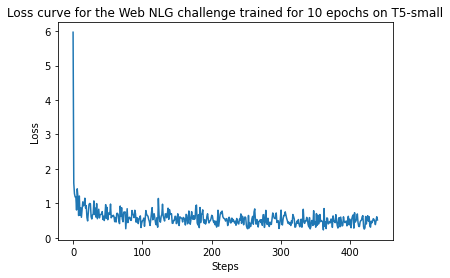

Running epoch: 2


Epoch: 2 , Running loss: 0.42914641094478695


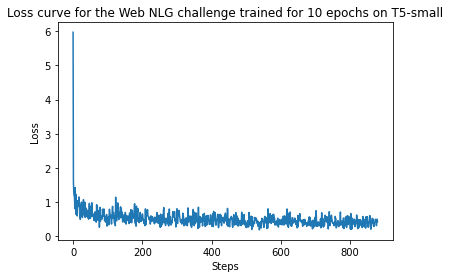

Running epoch: 3


Epoch: 3 , Running loss: 0.38449420661242173


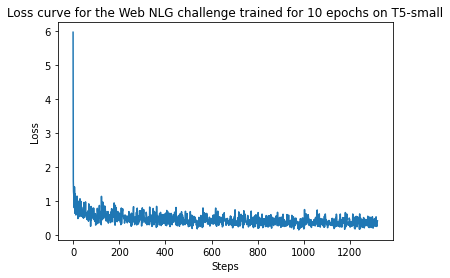

Running epoch: 4


Epoch: 4 , Running loss: 0.3559549996510825


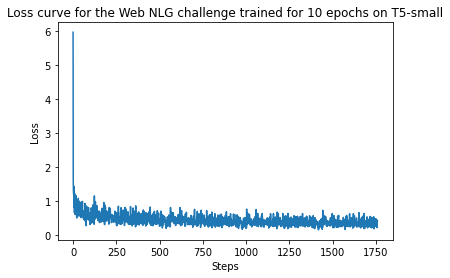

Running epoch: 5


Epoch: 5 , Running loss: 0.3340653362667019


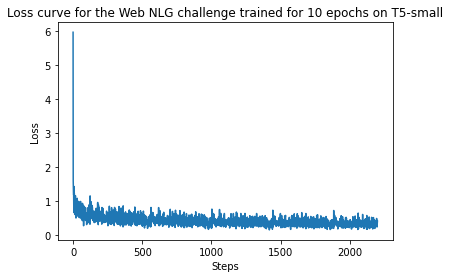

Running epoch: 6


Epoch: 6 , Running loss: 0.31696110804141925


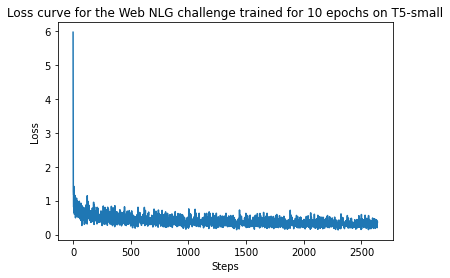

Running epoch: 7


Epoch: 7 , Running loss: 0.30263587714088236


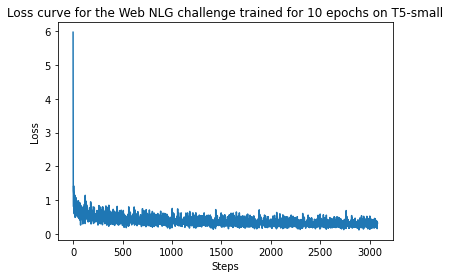

Running epoch: 8


Epoch: 8 , Running loss: 0.29031193989244375


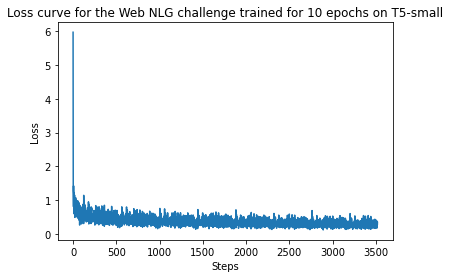

Running epoch: 9


Epoch: 9 , Running loss: 0.27941366230560977


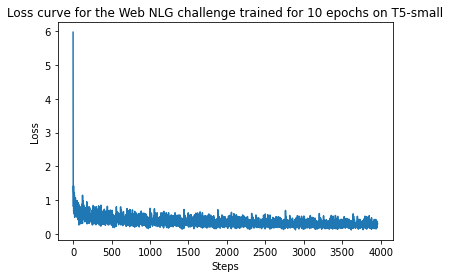

Running epoch: 10


Epoch: 10 , Running loss: 0.2691831519048322


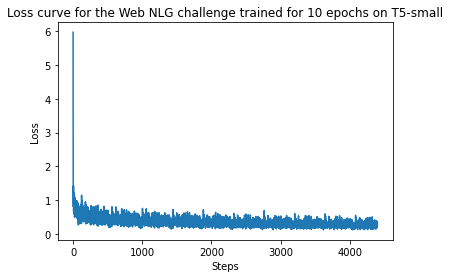

In [ ]:
# Train T5 small on Web NLG
model_t5_small_web_nlg = trainer(model=model_t5_small_web_nlg, 
                         num_batches=number_of_batches_train_web_nlg, 
                         inputs=inputs_train_web_nlg, 
                         labels=labels_train_web_nlg,
                         optimizer=optimizer_t5_small_web_nlg,
                         challenge_name='Web NLG',
                         model_name='small')

In [ ]:
# Train T5 small on AMR
"""model_t5_small_amr = trainer(model=model_t5_small_amr, 
                         num_batches=number_of_batches_train_amr, 
                         inputs=inputs_train_amr, 
                         labels=labels_train_amr,
                         optimizer=optimizer_t5_small_amr,
                         challenge_name='AMR',
                         model_name='small')"""

In [ ]:
# Train T5 small on E2E
"""model_t5_small_e2e = trainer(model=model_t5_small_e2e, 
                         num_batches=number_of_batches_train_e2e, 
                         inputs=inputs_train_e2e, 
                         labels=labels_train_e2e,
                         optimizer=optimizer_t5_small_e2e,
                         challenge_name='E2E',
                         model_name='small')"""

## Evaluate a Model

In [ ]:
def evaluation(model, inputs_test, labels_test, tokenizer, metric_name):
  # load the metric (if it is included in datasets from huggingface), set the model to eval mode
  # and then generate outputs for the test set to compare them to the list of possible references
  metric = load_metric(metric_name)
  model_predictions = []
  model.eval()
  with torch.no_grad():
    for i in range(len(inputs_test)):
      output = tokenizer.batch_decode(model.generate(inputs_test[i]))
      model_predictions.append([x.replace('<pad>','').replace('</s>','') for x in output])

    # flatten the predictions list which has the length of batch_size * number_of_batches
    model_predictions = list(chain(*model_predictions))  

    print(model_predictions[:20])
    #print([[x] for x in labels_test][0])
    print(labels_test[:20])

    bleu_score = metric.compute(predictions=model_predictions, references=labels_test)

    print(list(bleu_score.keys()))
    print(round(bleu_score["score"], 1))

  model.train()

  return bleu_score
  

In [44]:
evaluation(model=model_t5_small_web_nlg, 
            inputs_test=inputs_test_web_nlg,
            labels_test=test_data_web_nlg['references_list'],
            tokenizer=tokenizer_t5_small,
            metric_name='sacrebleu')

In [ ]:
evaluation(model=model_t5_small_e2e, 
           inputs_test=inputs_test_e2e,
           labels_test=test_data_e2e['references_list'],
           tokenizer=tokenizer_t5_small,
           metric_name='sacrebleu')

In [ ]:
"""evaluation(model=model_t5_small_amr, 
           inputs_test=inputs_test_amr, 
           labels_test=[[x] for x in test_data_amr['target_text']], 
           tokenizer=tokenizer,
           metric_name='sacrebleu')"""

## Save the Model

In [ ]:
torch.save(model_t5_small_web_nlg.state_dict(),f'drive/MyDrive/MIwDL/models/25_epochs_t5_small/t5_small_web_nlg_{epochs}_epochs_batch_size_{batch_size_web_nlg}_optimized_inputs.bin')

In [ ]:
torch.save(model_t5_small_e2e.state_dict(),f'drive/MyDrive/MIwDL/models/25_epochs_t5_small/t5_small_e2e_{epochs}_epochs_batch_size_{batch_size_e2e}.bin')

## Load a model

In [48]:
!wget https://s3.amazonaws.com/models.huggingface.co/bert/t5-small-config.json
#!wget https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json
#!wget https://s3.amazonaws.com/models.huggingface.co/bert/t5-large-config.json

model_t5_small_e2e = T5ForConditionalGeneration.from_pretrained('drive/MyDrive/MIwDL/models/25_epochs_t5_small/t5_small_web_nlg_25_epochs_batch_size_8.bin', 
                                                                    return_dict=True,
                                                                    config='t5-small-config.json')

if torch.cuda.is_available():
    dev = torch.device("cuda:0")
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

model_t5_small_e2e.to(dev)

tokenizer_t5_small = T5Tokenizer.from_pretrained('t5-small')


--2022-01-08 19:00:24--  https://s3.amazonaws.com/models.huggingface.co/bert/t5-small-config.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.94.222
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.94.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1197 (1.2K) [application/json]
Saving to: ‘t5-small-config.json.3’

t5-small-config.jso 100%[===================>]   1.17K  --.-KB/s    in 0s      

2022-01-08 19:00:24 (11.8 MB/s) - ‘t5-small-config.json.3’ saved [1197/1197]

Running on the GPU
